Remaining Columns After Dropping Irrelevant Features:
 Index(['TotalCharge', 'Initial_days', 'Additional_charges', 'Doc_visits',
       'Age', 'Income', 'Complication_risk', 'Initial_admin', 'Diabetes'],
      dtype='object')
Missing Values After Imputation:
 TotalCharge           0
Initial_days          0
Additional_charges    0
Doc_visits            0
Age                   0
Income                0
Complication_risk     0
Initial_admin         0
Diabetes              0
dtype: int64
Dataset After Encoding:
    TotalCharge  Initial_days  Additional_charges  Doc_visits       Age  \
0     8.223547      2.449778            9.794811    1.945910  3.988984   
1     8.341456      2.780654            9.776449    1.609438  3.951244   
2     7.797798      1.753049            9.770310    1.609438  3.988984   
3     7.663328      0.998747            9.472277    1.609438  4.369448   
4     7.656372      0.813064            8.220814    1.791759  3.135494   

      Income  Diabetes  Complication_risk

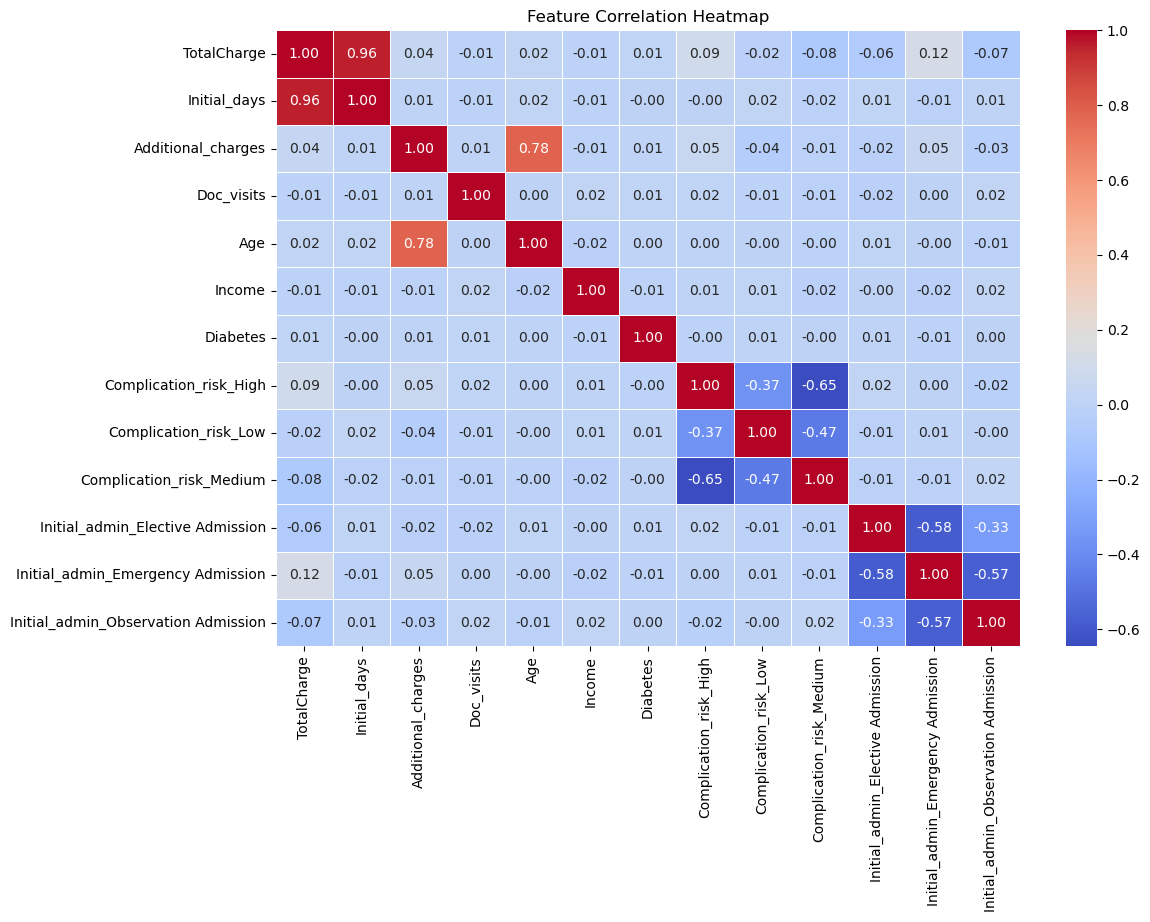

Cleaned dataset saved successfully.


In [19]:
# Data Preprocessing & Correlation Heatmap Creation

# A: Import Libraries and Load Data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Load dataset
df = pd.read_csv("medical_original.csv")

# Step 2: Select Relevant Features
selected_columns = ['TotalCharge', 'Initial_days', 'Additional_charges', 'Doc_visits', 
                    'Age', 'Income', 'Complication_risk', 'Initial_admin', 'Diabetes']
df_cleaned = df[selected_columns].copy()

print("Remaining Columns After Dropping Irrelevant Features:\n", df_cleaned.columns)

# C Handle Missing Values (Median Imputation)
imputer = SimpleImputer(strategy='median')  
df_cleaned.loc[:, ["Initial_days", "Additional_charges", "Doc_visits", "Age", "Income"]] = imputer.fit_transform(
    df_cleaned[["Initial_days", "Additional_charges", "Doc_visits", "Age", "Income"]]
)

print("Missing Values After Imputation:\n", df_cleaned.isnull().sum())

# D: Apply Log Transformation for Continuous Variables
continuous_vars = ['TotalCharge', 'Initial_days', 'Additional_charges', 'Doc_visits', 'Age', 'Income']
df_cleaned[continuous_vars] = np.log1p(df_cleaned[continuous_vars])

# E: Encode Categorical Variables
df_cleaned = pd.get_dummies(df_cleaned, columns=['Complication_risk', 'Initial_admin'])  
df_cleaned['Diabetes'] = df_cleaned['Diabetes'].map({'Yes': 1, 'No': 0})

print("Dataset After Encoding:\n", df_cleaned.head())

# F: Feature Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_cleaned.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# G: Save Cleaned Dataset
df_cleaned.to_csv("medical_cleaned.csv", index=False)
print("Cleaned dataset saved successfully.")


In [21]:
# Create Testing and Training Sets 

# Load the Cleaned Dataset
df_cleaned = pd.read_csv("medical_cleaned.csv")  

# Define Features (X) and Target Variable (y)
X = df_cleaned.drop(columns=['TotalCharge'])  
y = df_cleaned['TotalCharge'].squeeze() 

# Split Dataset (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Save Training and Testing Datasets
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv("medical_train_2.csv", index=False)
test_data.to_csv("medical_test_2.csv", index=False)

print("Training and testing datasets successfully saved as 'medical_train_2.csv' and 'medical_test_2.csv'.")


Training and testing datasets successfully saved as 'medical_train_2.csv' and 'medical_test_2.csv'.


In [23]:
# 1 Load the Libraries & Datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load training and testing data
train_data = pd.read_csv("medical_train_2.csv")
test_data = pd.read_csv("medical_test_2.csv")

# Define features (X) and target variable (y)
X_train = train_data.drop(columns=['TotalCharge'])  
y_train = np.log1p(train_data['TotalCharge'])  # Log-transform target
X_test = test_data.drop(columns=['TotalCharge'])
y_test = np.log1p(test_data['TotalCharge'])  # Log-transform target

print("\nData Loaded Successfully.")



Data Loaded Successfully.


In [25]:
# 2 Use GridSearch to find best tree count
from sklearn.model_selection import GridSearchCV

param_grid_trees = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None],  # Placeholder
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}

grid_search_trees = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_trees, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, return_train_score=True)
grid_search_trees.fit(X_train, y_train)

# Convert negative MSE to positive
results_trees = pd.DataFrame(grid_search_trees.cv_results_)
results_trees['mean_test_score'] = -results_trees['mean_test_score']  # Convert neg MSE back to positive

# Print results for tree counts
print("\nMSE Scores for Different Tree Counts (Lower = Better):")
print(results_trees[['param_n_estimators', 'mean_test_score']].sort_values(by='mean_test_score'))

# Get best tree count
best_tree_count = grid_search_trees.best_params_['n_estimators']
print(f"The best number of trees is: {best_tree_count}")



MSE Scores for Different Tree Counts (Lower = Better):
   param_n_estimators  mean_test_score
2                 200         0.000018
1                 100         0.000019
0                  50         0.000021
The best number of trees is: 200


In [27]:
# Depth Test 1: Use GridSearch to find the best tree depth 
param_grid_depth = {
    'n_estimators': [200],  # Fixed at 200 trees
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}

grid_search_depth = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_depth, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, return_train_score=True)
grid_search_depth.fit(X_train, y_train)

# Convert negative MSE to positive
results_depth = pd.DataFrame(grid_search_depth.cv_results_)
results_depth['mean_test_score'] = -results_depth['mean_test_score']  # Convert neg MSE back to positive

# Print results for max depth
print("\nMSE Scores for Different Tree Depths (Lower = Better):")
print(results_depth[['param_max_depth', 'mean_test_score']].sort_values(by='mean_test_score'))

# Get best depth
best_max_depth = grid_search_depth.best_params_['max_depth']
print(f"\nThe best tree depth is: {best_max_depth}")


MSE Scores for Different Tree Depths (Lower = Better):
   param_max_depth  mean_test_score
5               30         0.000018
4               25         0.000018
3               20         0.000019
2               15         0.000020
1               10         0.000038
0                5         0.000192

The best tree depth is: 30



Testing different max_depth values...

max_depth=1 → Train MSE: 0.0003, Test MSE: 0.0003
max_depth=2 → Train MSE: 0.0001, Test MSE: 0.0001
max_depth=3 → Train MSE: 0.0001, Test MSE: 0.0001
max_depth=4 → Train MSE: 0.0000, Test MSE: 0.0000
max_depth=5 → Train MSE: 0.0000, Test MSE: 0.0000


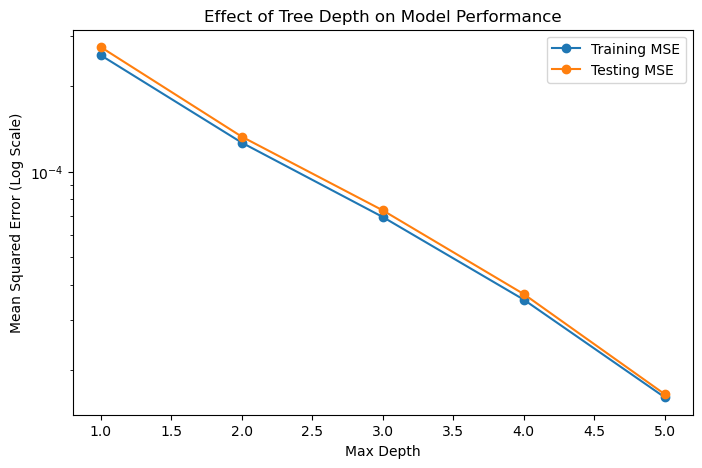


Max_depth with lowest MSE: 4


In [29]:
# Depth Test 2: Find best tree depth manually

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Define a wider range of depths for testing
depths = [1, 2, 3, 4, 5,]
train_errors = []
test_errors = []

print("\nTesting different max_depth values...\n")

# Train models with different max_depth values
for d in depths:
    rf = RandomForestRegressor(n_estimators=200, max_depth=d, random_state=42)
    rf.fit(X_train, y_train)
    
    # Predictions
    train_pred = rf.predict(X_train)
    test_pred = rf.predict(X_test)

    # Compute MSE
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    
    train_errors.append(train_mse)
    test_errors.append(test_mse)
    
    print(f"max_depth={d} → Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

# Plot the results with a log scale for better visualization
plt.figure(figsize=(8, 5))
plt.plot(depths, train_errors, label="Training MSE", marker='o', linestyle='-')
plt.plot(depths, test_errors, label="Testing MSE", marker='o', linestyle='-')
plt.xlabel("Max Depth")
plt.ylabel("Mean Squared Error (Log Scale)")
plt.yscale("log")  # Apply log scale for better visibility
plt.title("Effect of Tree Depth on Model Performance")
plt.legend()
plt.show()

# Manually choose the best depth based on test MSE trends
best_max_depth = 4
print(f"\nMax_depth with lowest MSE: {best_max_depth}")



Final Random Forest Model Parameters:

bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: 30
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 200
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False

Feature Importance Scores:
                                Feature  Importance
0                          Initial_days    0.925230
1                    Additional_charges    0.014655
4                                Income    0.013915
10    Initial_admin_Emergency Admission    0.011157
3                                   Age    0.010397
6                Complication_risk_High    0.006891
2                            Doc_visits    0.004895
11  Initial_admin_Observation Admission    0.003747
9      Initial_admin_Elective Admission    0.003401
8              Complication_risk_Medium    0.002811
5                   

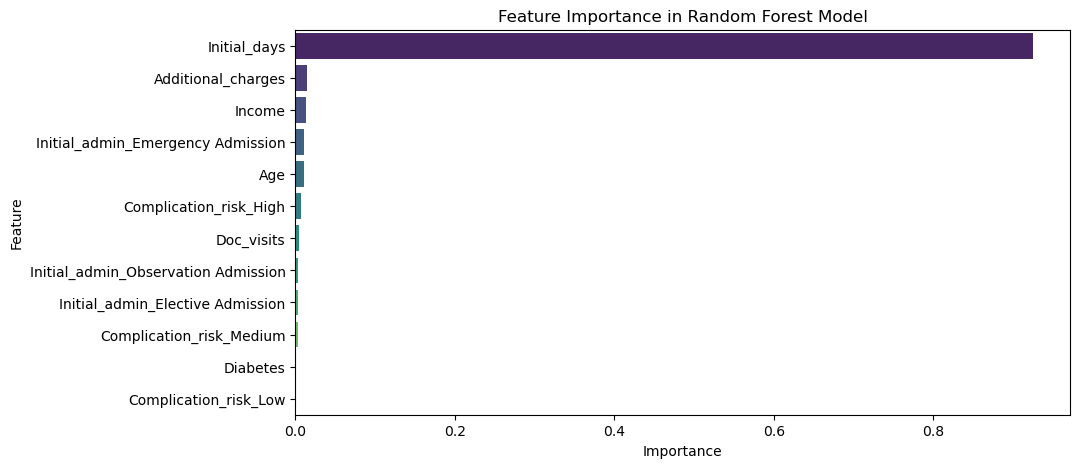


Final Model Evaluation Metrics:
Mean Squared Error (MSE): 0.0015
Root Mean Squared Error (RMSE): 0.0386
R² Score: 0.9924


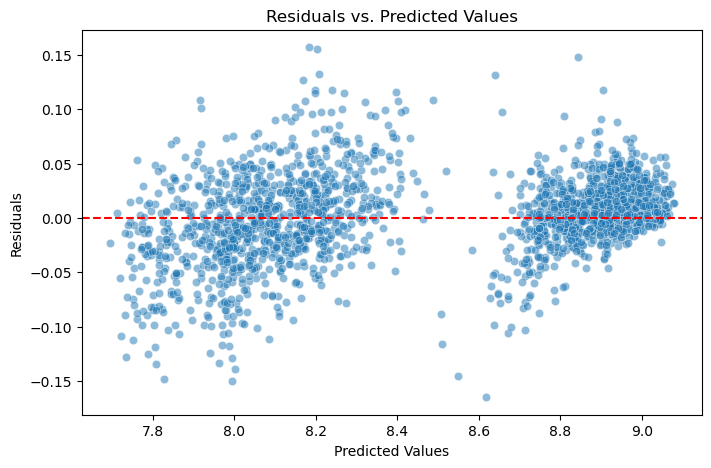

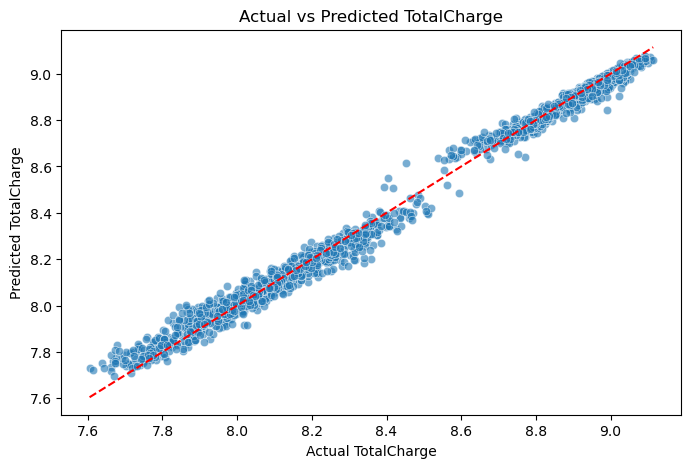

In [31]:
# 4: Train the Final Model & Show Calculations

import matplotlib.pyplot as plt
import seaborn as sns

# Train final model with best hyperparameters
best_params = grid_search_depth.best_params_

# Train the Random Forest model
rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_train, y_train)

# Format and print final model parameters neatly
print("\nFinal Random Forest Model Parameters:\n")
for key, value in rf_model.get_params().items():
    print(f"{key}: {value}")

# Step 1: Feature Importance Calculation
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print("\nFeature Importance Scores:")
print(feature_importances)

# Step 2: Feature Importance Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis', hue='Feature', legend=False)
plt.title("Feature Importance in Random Forest Model")
plt.show()

# Step 3: Make Predictions with Final Model
y_pred = rf_model.predict(X_test)

# Convert Predictions Back to Original Scale
y_pred = np.expm1(y_pred)
y_test = np.expm1(y_test)

# Compute final evaluation metrics
mse_final = mean_squared_error(y_test, y_pred)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y_test, y_pred)

print("\nFinal Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_final:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_final:.4f}")
print(f"R² Score: {r2_final:.4f}")

# Step 4: Residual Plot (Actual - Predicted)
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()

# Step 5: Scatter Plot of Actual vs Predicted Values
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Perfect fit line
plt.title("Actual vs Predicted TotalCharge")
plt.xlabel("Actual TotalCharge")
plt.ylabel("Predicted TotalCharge")
plt.show()
